# arXiv heatmap
### Usage stats data collection

For the short-term forecast to make sense and be usable, we need to make sure that we understand the daily usage of the arXiv.  We can luckily obtain daily usage directly from the arXiv as a `csv` file with the API `https://arxiv.org/stats/get_hourly?date=yyyymmdd`.

##### Toy case
To demonstrate, here are the usage stats for June 3, 2025.

In [1]:
import pandas as pd

june5 = pd.read_csv("https://arxiv.org/stats/get_hourly?date=20250603")

Here is how the loaded table looks like.  The `node1` column represents the total number of connections per hour (to the [arxiv.org](https://arxiv.org) site only).

In [2]:
june5

,hour,node1
0,2025-06-03T00:00:00Z,3776905
1,2025-06-03T01:00:00Z,3880455
2,2025-06-03T02:00:00Z,4539216
3,2025-06-03T03:00:00Z,4639824
4,2025-06-03T04:00:00Z,4614698
5,2025-06-03T05:00:00Z,4244343
6,2025-06-03T06:00:00Z,3800650
7,2025-06-03T07:00:00Z,3768012
8,2025-06-03T08:00:00Z,3928061
9,2025-06-03T09:00:00Z,3998370


We only care about daily totals, i.e. the sum of `node1`.

In [3]:
june5.node1.sum()

np.int64(85231556)

##### The actual data collection
Now that we understand the workings of data collection, we can do it programmatically to obtain a dataset of daily usage of the arXiv.  We do it this way:
- load `data/totals.parquet` to have a list of the dates papers were posted
- use the indexes of `arxiv_totals` to access the usage stats API
- sum the daily totals and save them as a dictionary
- transform the dictionary into a dataframe and export it as parquet

We load the data.

In [4]:
arxiv_totals = pd.read_parquet("../../data/arxiv-totals.parquet")

From a quick search of the data from the API, it seems that arXiv was not tracking daily usage before Jan 1, 2024 (or, at least, it's not accessible via that API).  Hence, our data series will start on that date.

In [5]:
import time

usage_list = []

for index in arxiv_totals[arxiv_totals.index >= pd.Timestamp(2024, 1, 1)].index:
    day_usage_stats = pd.read_csv(
        "https://arxiv.org/stats/get_hourly?date=" + str(index.strftime("%Y%m%d"))
    )
    usage_list.append(tuple([index, day_usage_stats.node1.sum()]))

    # arXiv allows 1 request every 3 seconds, for our use here it means that it will take about 20 minutes
    time.sleep(3)

usage = pd.DataFrame(usage_list).set_index(0)

We have a look at `usage` by looking at the dataframe itself and a crude plot.

In [6]:
usage

,1
0,
2024-01-01,43626111
2024-01-02,54640750
2024-01-03,56101036
2024-01-04,50084378
2024-01-05,48182775
...,...
2025-04-06,42500085
2025-04-07,57708551
2025-04-08,57728496


<Axes: xlabel='0'>

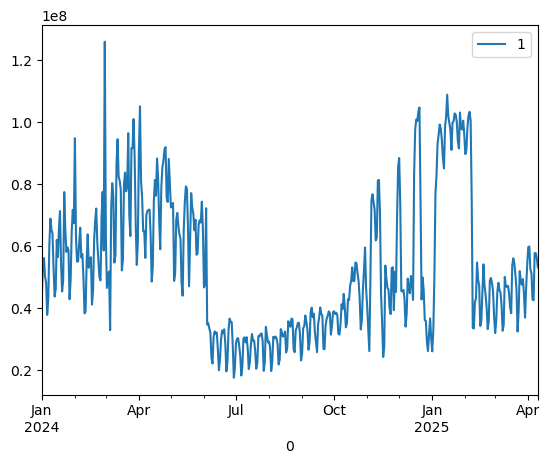

In [7]:
usage.plot()

Finally, we save `usage` as `data/arxiv-usage.parquet`.

In [8]:
usage.to_parquet("../../data/arxiv-usage.parquet")

/home/roberto/anaconda3/envs/arxiv-heatmaps/lib/python3.13/site-packages/pandas/io/parquet.py:480: UserWarning: The DataFrame has non-str index name `[0]` which will be converted to string and not roundtrip correctly.
  impl.write(
